In [103]:

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [104]:
data = pd.read_csv("usa.csv")

/var/folders/4j/1f114zrx3hj5wfsm86df6nfw0000gn/T/ipykernel_46871/3460310798.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("usa.csv")


KeyboardInterrupt: 

In [ ]:
cols = ["be_me", "ret_12_1", "market_equity", "ret_1_0", "rvol_252d", "beta_252d", "qmj_safety", "rmax1_21d",
        "chcsho_12m", "ni_me", "eq_dur", "ret_60_12", "ope_be", "gp_at", "ebit_sale", "at_gr1", "sale_gr1",
        "at_be", "cash_at", "age", "z_score"]


data['date_str'] = data['date']
data['date'] = pd.to_datetime(data['date_str'], format='%Y%m%d') 
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data[data['year']>=1980]

# drop missing observations
data = data.dropna(subset=['me','ret_exc_lead1m','permno'])

# exclude nano caps
data = data[data['size_grp'] != 'nano']

# delete observation with more than 5 out of the 21 characteristics missing
data["missing_num"] = data[cols].isna().sum(axis=1)
data = data[data['missing_num'] <= 10]

# impute the missing characteristics by replacing them with the cross-sectional median
for i in cols:
    data[i] = data[i].fillna(data.groupby('date')[i].transform('median'))


# rank transformation following Gu-Kelly-Xiu 2020 RFS
# each characteristic is transformed into the cross-sectional rank
for i in cols:
    data[i] = 2*data.groupby('date')[i].rank(pct=True) - 1 


# Check for missing values
df = data
null = df[df.isnull().any(axis=1)]

In [118]:
alpha_grid = [0.0001, 0.0002, 0.0005] #
l1_ratio_grid = np.linspace(0, 1, 21)  # [0.0, 0.1, ..., 1.0]

validation_accuracy = []
test_accuracy = []
alphas = []
models = []

rets_ls_vw = np.zeros(264)
rets_l_vw = np.zeros(264)

In [ ]:
i=0
for train_start in tqdm(range(1980,2002)):
#for train_start in range (1980,1981):09809
    print("processing--")
    print(train_start)
    train_end = train_start + 9
    validate_start = train_end + 1
    validate_end = validate_start + 4
    test_start = validate_end + 1
    test_end = test_start
    
    x_train = data[ (data['year']>=train_start) & (data['year']<=train_end) ]
    x_train = x_train.drop( x_train[(x_train['year']==train_end) & (x_train['month']==12)].index )
    #y_train
    x_train['ranked_y'] = x_train.groupby("date")['ret_exc_lead1m'].rank(pct=True, method='min')
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # Apply the transformation
    x_train['new_y'] = pd.cut(x_train['ranked_y'], bins=bins, labels=labels, include_lowest=True)
    x_train['new_y'] = x_train['new_y'].astype('category')
    y_train = x_train["new_y"].to_numpy()

    #xtrrain
    x_train = x_train[cols]

    #x_validate
    x_validate = data[ (data['year']>=validate_start) & (data['year']<=validate_end) ]
    x_validate = x_validate.drop( x_validate[(x_validate['year']==validate_end) & (x_validate['month']==12)].index )
    #y_validate
    x_validate['ranked_y'] = x_validate.groupby("date")['ret_exc_lead1m'].rank(pct=True, method='min')
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # Apply the transformation
    x_validate['new_y'] = pd.cut(x_validate['ranked_y'], bins=bins, labels=labels, include_lowest=True)
    x_validate['new_y'] = x_validate['new_y'].astype('category')
    y_validate = x_validate["new_y"].to_numpy()

    #x_validate
    x_validate = x_validate[cols]
    
    best_accuracy, best_model, best_alpha = -1, None, None
    for alpha in alpha_grid:
            model = LogisticRegression(multi_class='multinomial', 
                                      solver='saga',
                                      C = alpha,
                                      n_jobs=-1,
                                      penalty='l1')
            model.fit(x_train, y_train)
            preds = model.predict(x_validate)
            accuracy = accuracy_score(y_validate, preds)
            if accuracy > best_accuracy:
                best_accuracy, best_model, best_alpha = accuracy, model, alpha
    
    validation_accuracy.append(best_accuracy)
    alphas.append(best_alpha)
    models.append(best_model)



    x_test = data[ (data['year']>=test_start) & (data['year']<=test_end) ]
    
    #y_test
    x_test['ranked_y'] = x_test.groupby("date")['ret_exc_lead1m'].rank(pct=True, method='min')
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # Apply the transformation
    x_test['new_y'] = pd.cut(x_test['ranked_y'], bins=bins, labels=labels, include_lowest=True)
    x_test['new_y'] = x_test['new_y'].astype('category')
    y_test = x_test[["new_y","month"]]

    y_pred = best_model.predict(x_test[cols])

    y_pred = pd.DataFrame(np.vstack((y_pred,x_test['month'])).T)

    # Calculate R-squared for the month
    for month in range(1, 13):
        y_test_month = y_test[y_test['month']==month]['new_y']
        y_pred_month = y_pred[y_pred[1]==month][0]
        
        accuracy = accuracy_score(y_test_month, y_pred_month)
        test_accuracy.append(accuracy)


        y_true = data[ (data['year']>=test_start) & (data['year']<=test_end) ][['ret_exc_lead1m','month']]
        y_true_month = y_true[y_true['month'] == month]['ret_exc_lead1m']

        size_train = x_test[x_test['month']==month]["market_equity"]
        pred_true_combined = np.vstack((y_pred_month,y_true_month,size_train)).T
        pred_true_combined = pd.DataFrame(pred_true_combined)
        pred_true_combined.columns = ["pred","true","size"]
        pred_true_combined['true_size'] = pred_true_combined[["true"]].multiply(pred_true_combined["size"], axis="index")
        pred_true_combined = np.array(pred_true_combined)

        num_stocks = pred_true_combined.shape[0] // 10
        highest_indices = get_top_10_percent_indices(pred_true_combined[:,0])
        lowest_indices = get_bottom_10_percent_indices(pred_true_combined[:,0])


        rets_ls_vw[i] = 0.5*(np.sum(pred_true_combined[highest_indices,3])/np.sum(pred_true_combined[highest_indices,2]) - 
                            np.sum(pred_true_combined[lowest_indices,3])/np.sum(pred_true_combined[lowest_indices,2]))
        rets_l_vw[i] = np.sum(pred_true_combined[highest_indices,3])/np.sum(pred_true_combined[highest_indices,2])
        i+=1




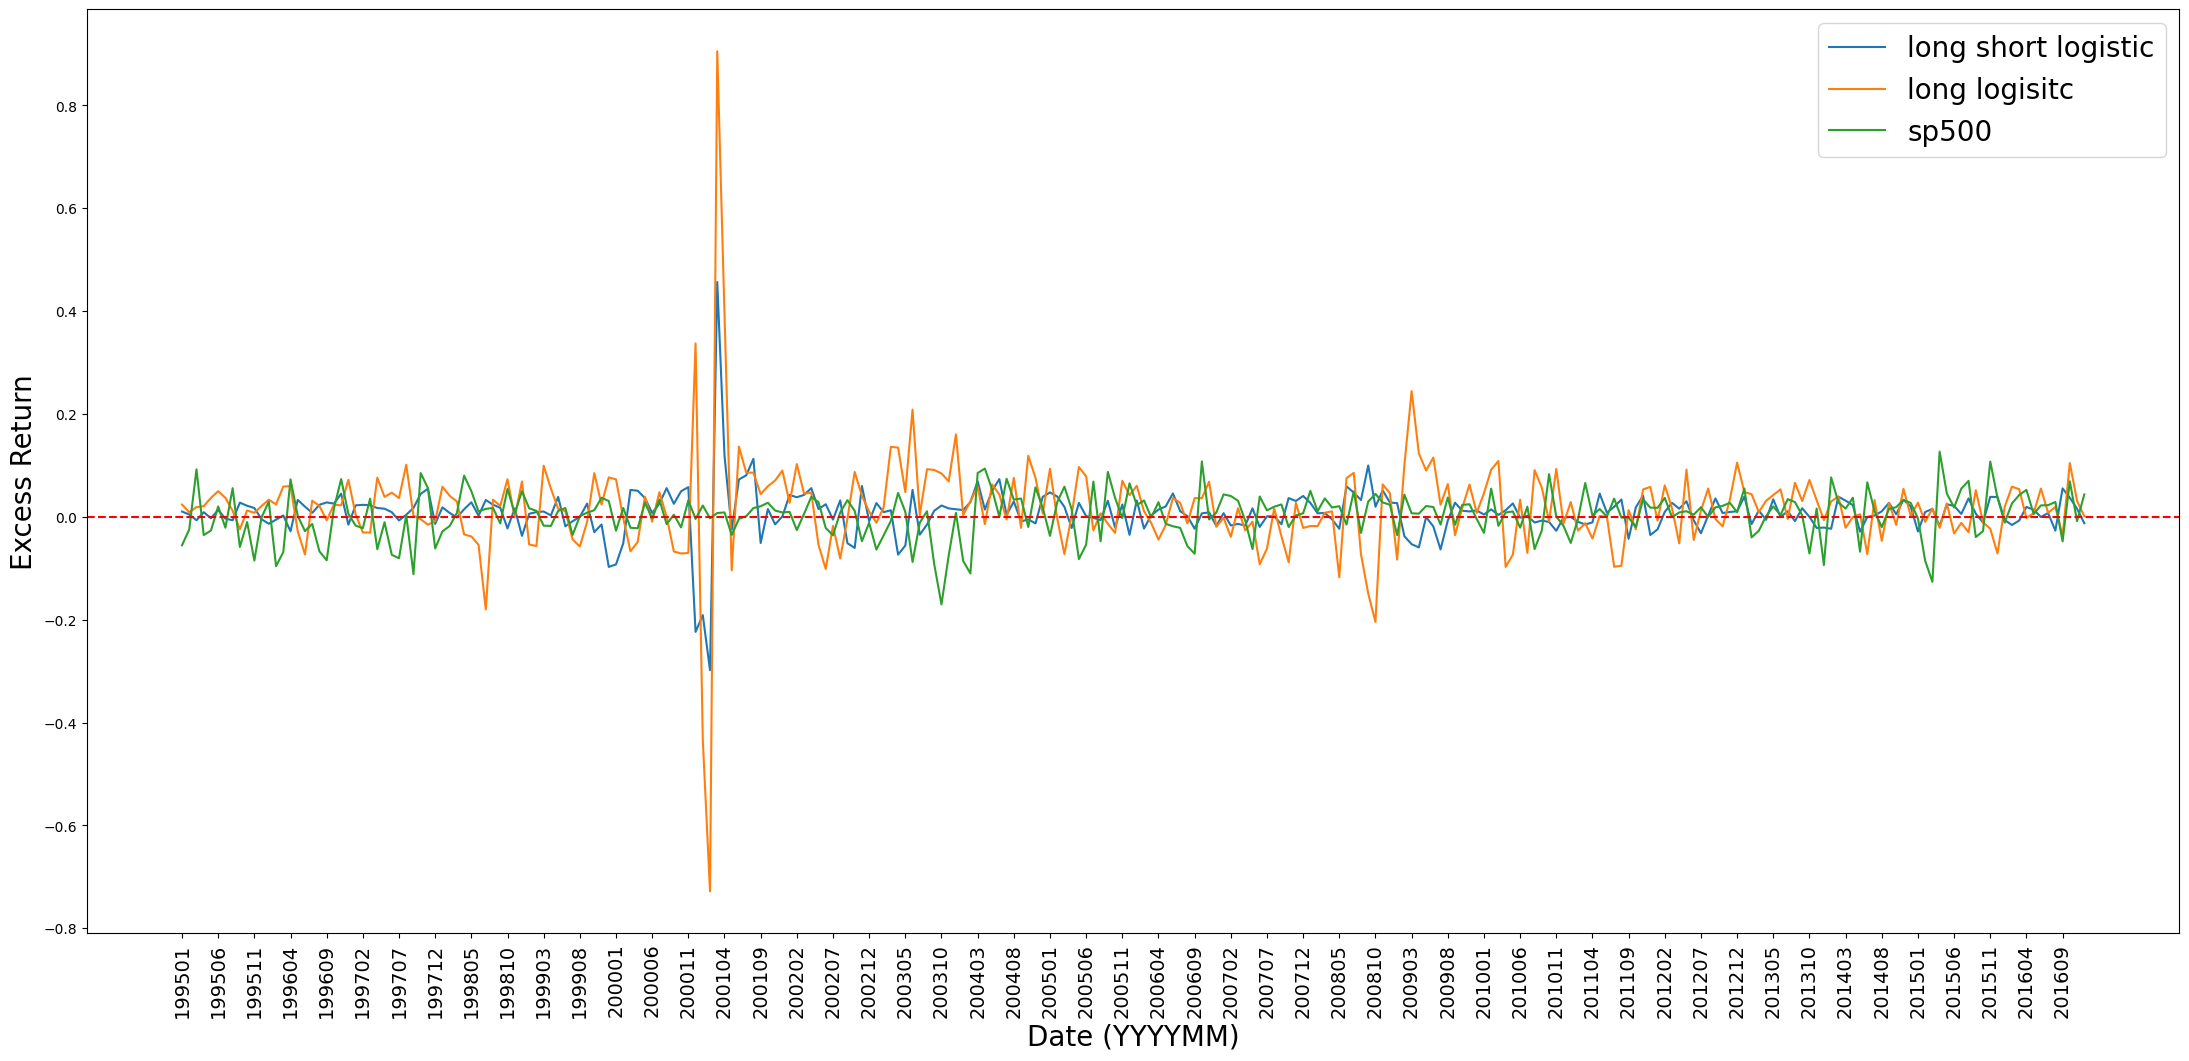

In [123]:
import pickle

plt.figure(figsize=(27, 12))

with open("output/sp500.pkl", "rb") as f:
    sp500 = pickle.load(f)
    sp500 = sp500[324-264:]

obj_month_list = [f"{year}{month:02d}" for year in range(1995, 2017) for month in range(1, 13)]
plt.plot(obj_month_list, rets_ls_vw, label="long short logistic")
plt.plot(obj_month_list, rets_l_vw, label="long logisitc")
plt.plot(obj_month_list, sp500, label="sp500")

plt.axhline(0, color='r', linestyle="--")
# plt.plot(test_months, validation_r2s, label="R^2 in validation years")
plt.xticks(obj_month_list[::5], rotation='vertical', fontsize=14)
plt.xlabel('Date (YYYYMM)', fontsize=20)
plt.ylabel('Excess Return', fontsize=20)
plt.legend(fontsize=20)
plt.show()

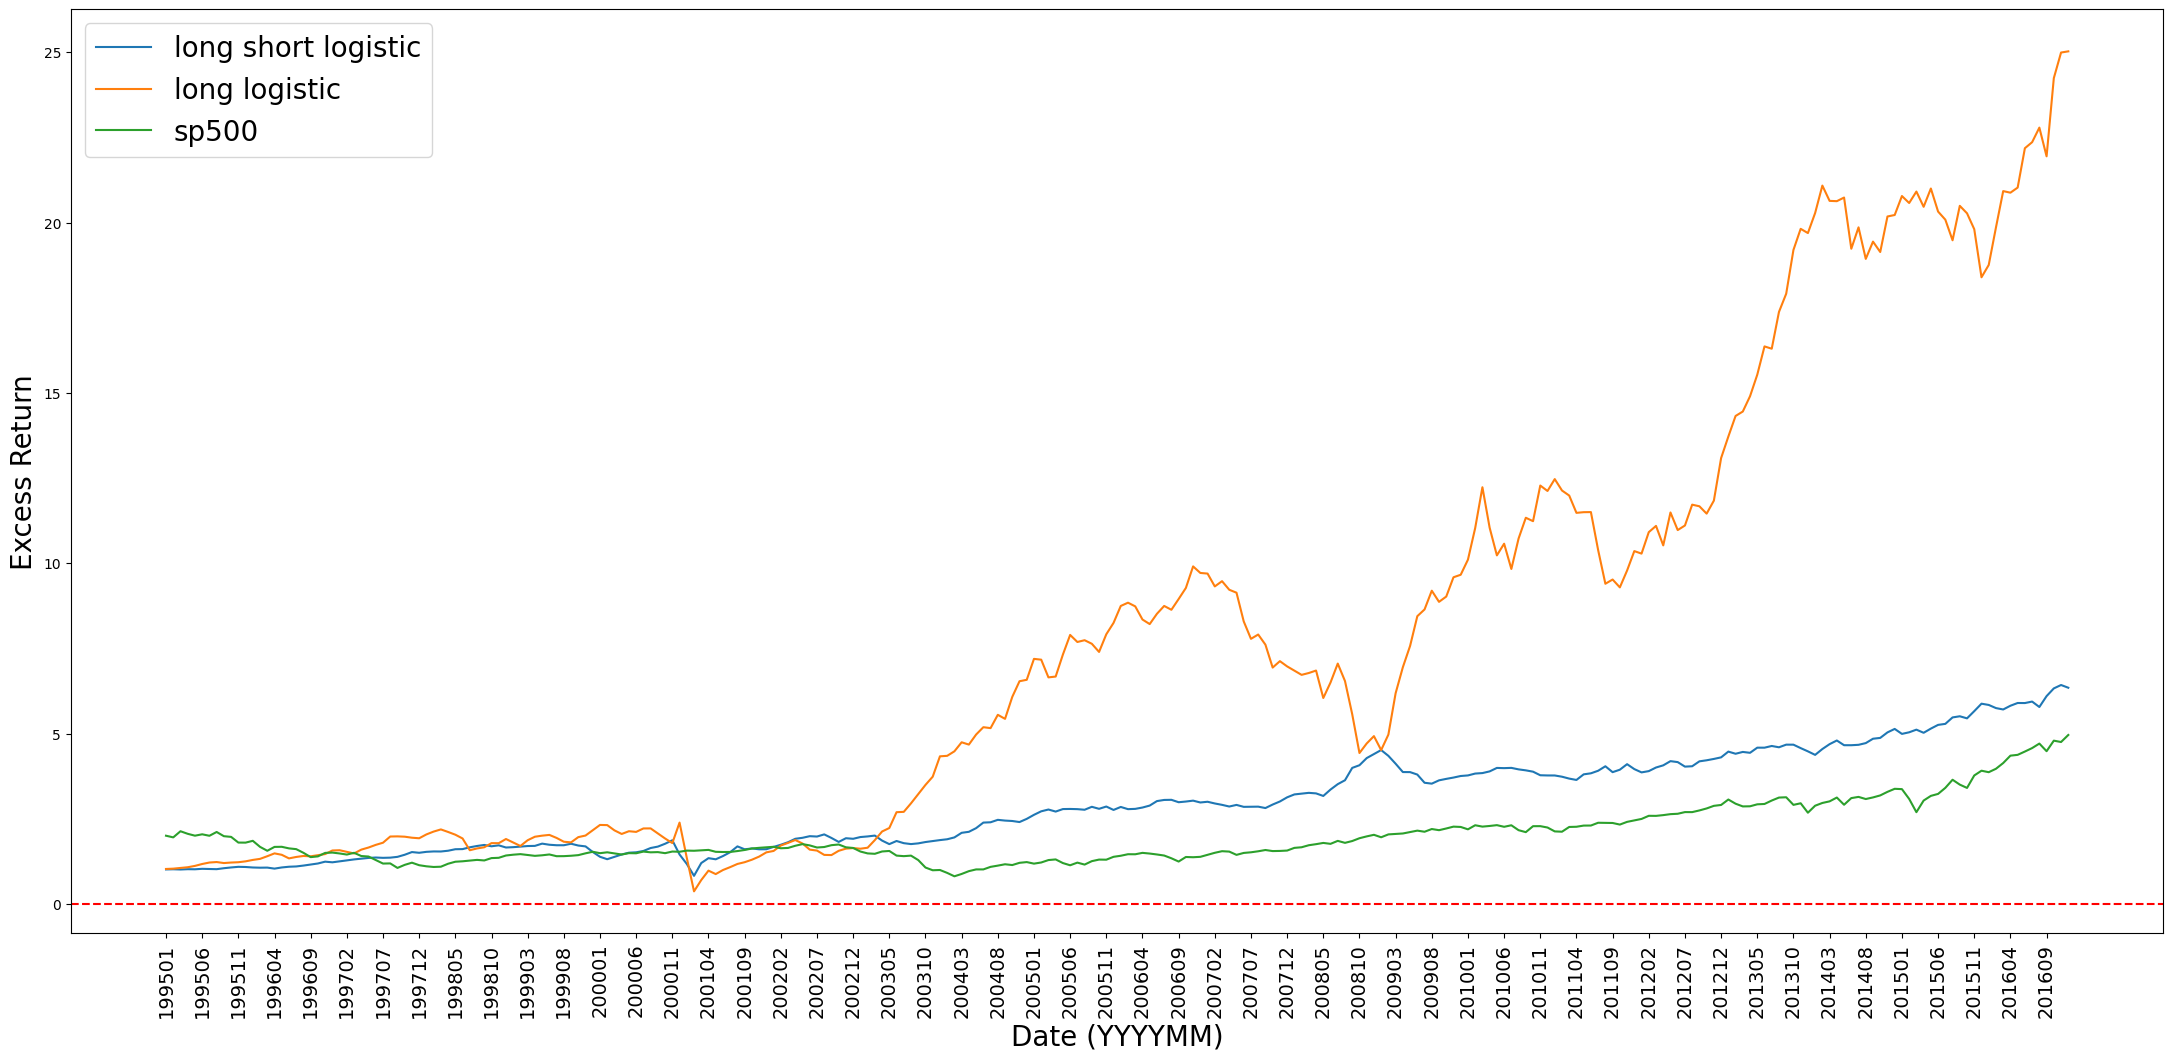

In [124]:
sp500[0] = 1
def adjusted_cumulative_product(array):
    adjusted_array = []
    cumulative_product = 1
    for value in array:
        adjusted_value = 1 + value
        cumulative_product *= adjusted_value
        adjusted_array.append(cumulative_product)
    return adjusted_array


accum_long_short_eNet = adjusted_cumulative_product(rets_ls_vw)
accum_long_eNet = adjusted_cumulative_product(rets_l_vw)
accum_sp500 = adjusted_cumulative_product(sp500)

plt.figure(figsize=(27, 12))


plt.plot(obj_month_list, accum_long_short_eNet, label="long short logistic")
plt.plot(obj_month_list, accum_long_eNet, label="long logistic")

plt.plot(obj_month_list, accum_sp500, label="sp500")

plt.axhline(0, color='r', linestyle="--")
# plt.plot(test_months, validation_r2s, label="R^2 in validation years")
plt.xticks(obj_month_list[::5], rotation='vertical', fontsize=14)
plt.xlabel('Date (YYYYMM)', fontsize=20)
plt.ylabel('Excess Return', fontsize=20)
plt.legend(fontsize=20)
plt.show()




In [ ]:
def get_top_10_percent_indices(arr):
    # Calculate the number of elements corresponding to the top 10%
    top_10_percent = int(0.1 * len(arr))
    
    # Create an array of indices from 0 to len(arr) - 1
    indices = np.arange(len(arr))
    
    # Shuffle the indices randomly
    np.random.shuffle(indices)
    
    # Use argsort to sort the shuffled indices based on the corresponding elements in arr
    sorted_indices = indices[np.argsort(arr[indices])]
    
    # Get the indices of the top 10% values
    top_10_percent_indices = sorted_indices[-top_10_percent:]
    
    return top_10_percent_indices

def get_bottom_10_percent_indices(arr):
    # Calculate the number of elements corresponding to the bottom 10%
    bottom_10_percent = int(0.1 * len(arr))
    
    # Create an array of indices from 0 to len(arr) - 1
    indices = np.arange(len(arr))
    
    # Shuffle the indices randomly
    np.random.shuffle(indices)
    
    # Use argsort to sort the shuffled indices based on the corresponding elements in arr
    sorted_indices = indices[np.argsort(arr[indices])]
    
    # Get the indices of the bottom 10% values
    bottom_10_percent_indices = sorted_indices[:bottom_10_percent]
    
    return bottom_10_percent_indices
